Saved: question_index_aligned_P.csv


,Code,Question_G1,Question_G2
0,P1,I enjoyed participating in the classroom activ...,I enjoyed participating in the classroom activ...
1,P2,The classroom activity was interesting and hel...,The classroom activity was interesting and hel...
2,P3,I felt motivated to participate actively in my...,I felt motivated to participate actively in my...
3,P4,The activity helped me better understand the c...,The activity helped me better understand the c...
4,P5,The practical exercise was more useful than ju...,The practical exercise was more useful than ju...
5,P6,I would like this type of activity to be inclu...,I would like this type of activity to be inclu...
6,P7,I can apply what I learned in this activity in...,I can apply what I learned in this activity in...
7,P8,Designing the architecture helped me connect t...,Designing the architecture helped me connect t...
8,P9,The instructions were clear and easy to follow.,The instructions were clear and easy to follow.
9,P10,"The support material (cheat sheet, guide) was ...","The support material (cheat sheet, guide) was ..."


Saved: Section_1._Satisfaction_and_Motivation.eps


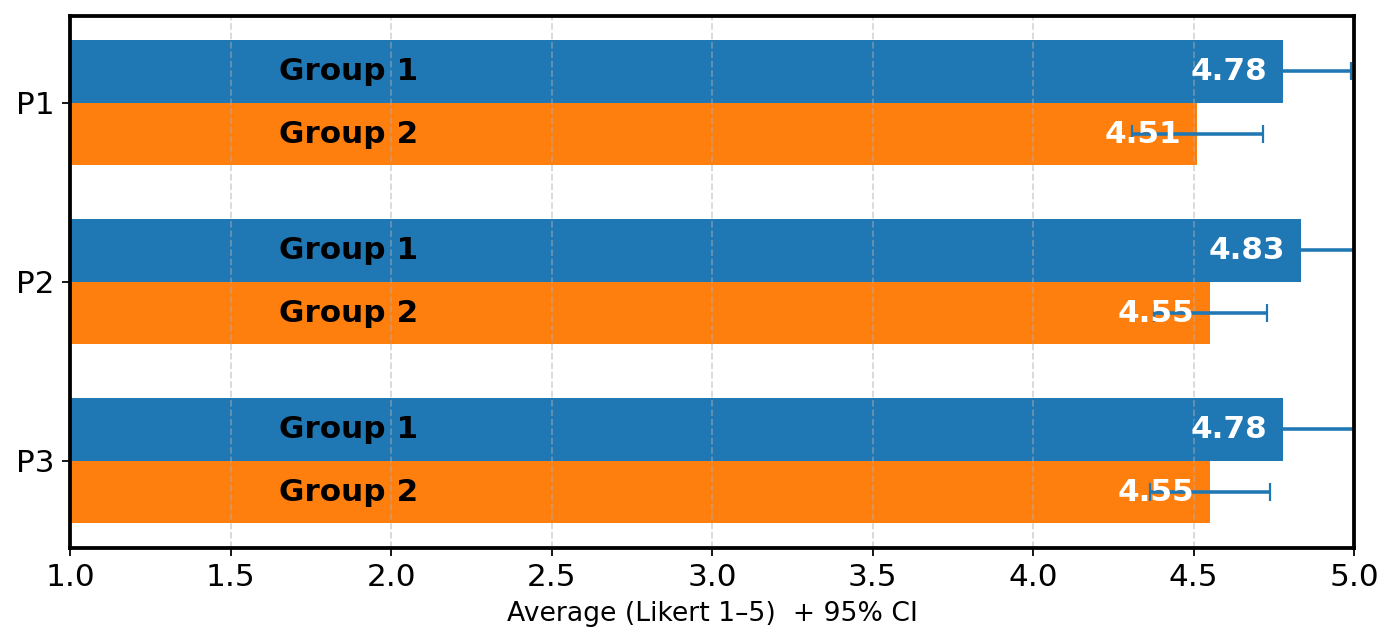

Saved: Section_2._Learning_Usefulness_I.eps


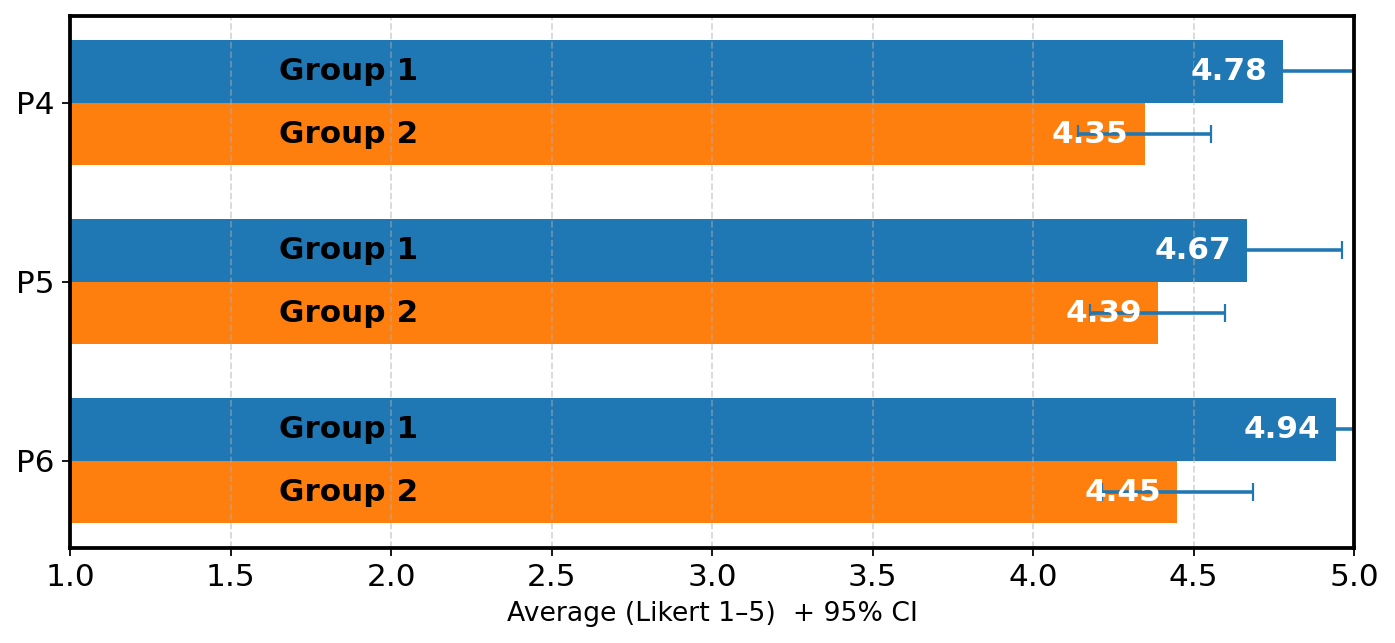

Saved: Section_3._Learning_Usefulness_II.eps


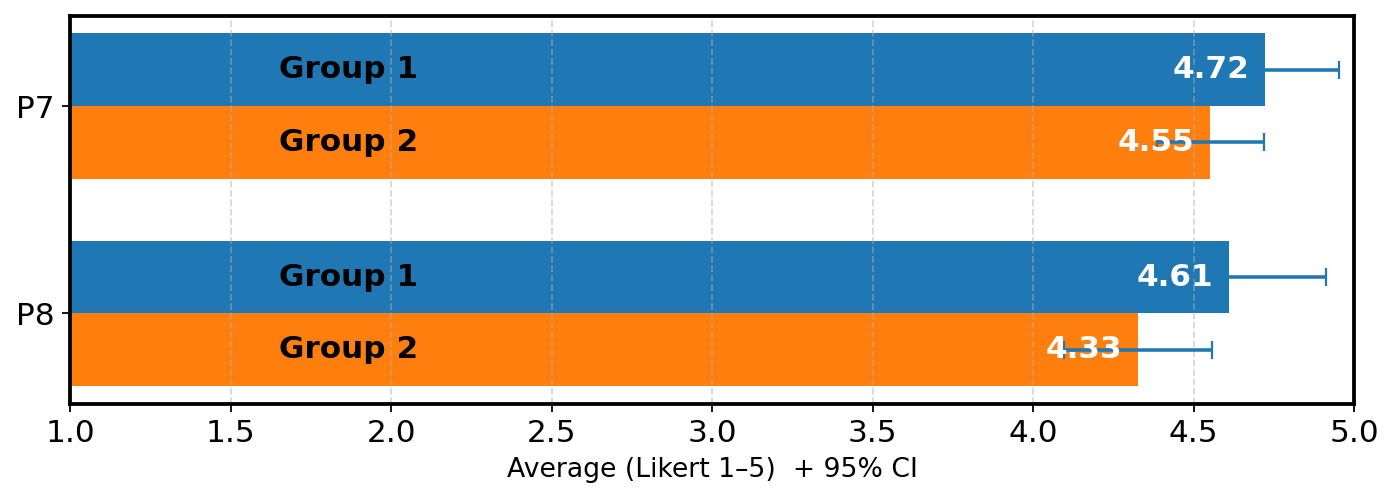

Saved: Section_4._Classroom_Methodology.eps


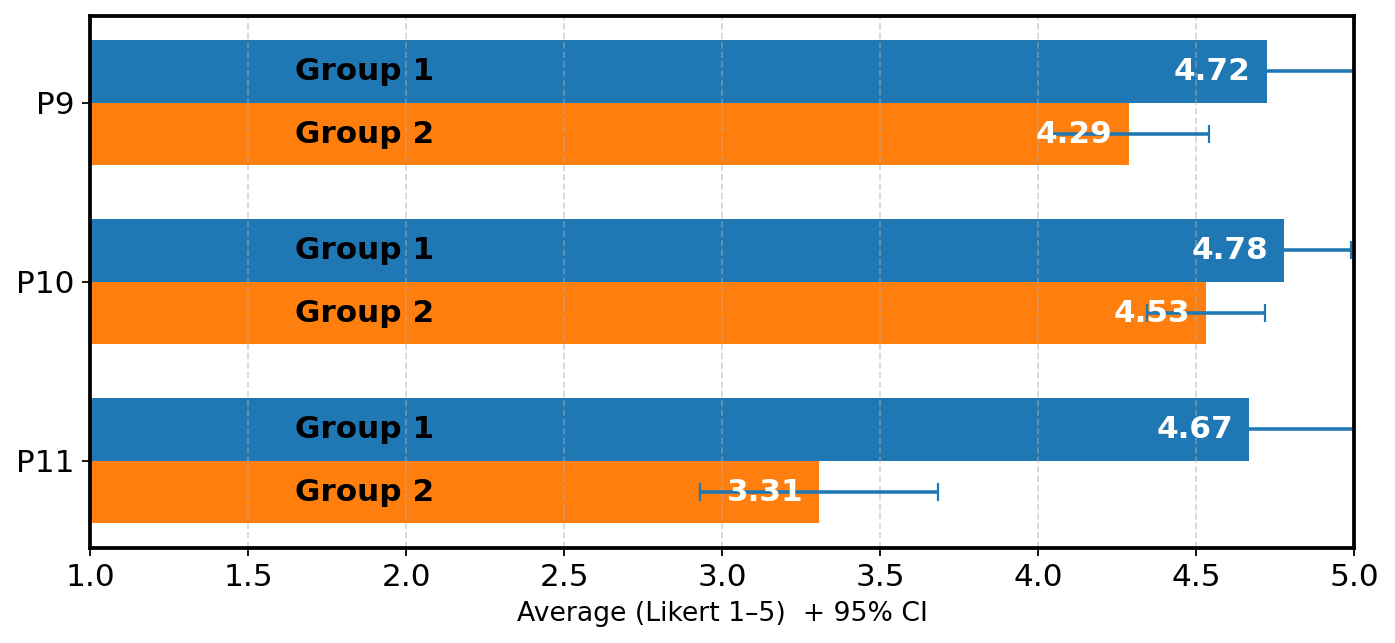

Saved: Section_5._Collaboration_and_Discussion.eps


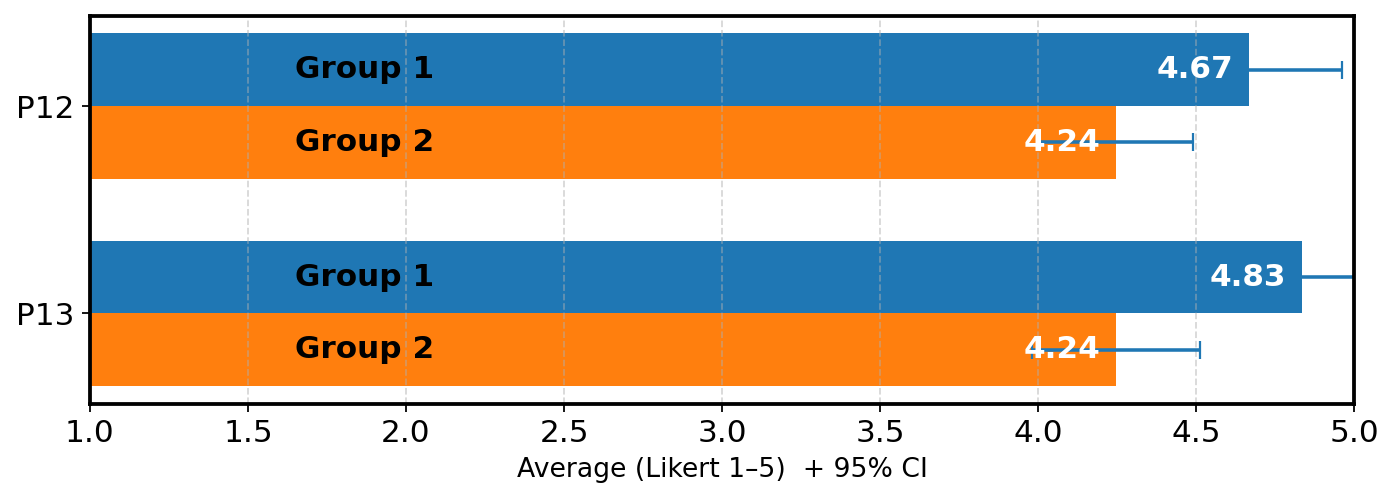

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import unicodedata, re
from difflib import get_close_matches
import numpy as np
from scipy.stats import t


# =========================
# 0) Paths
# =========================
PATH_G1 = "/content/survey_results_group1.csv" #GROUP 1 RESULTS
PATH_G2 = "/content/survey_results_group2.csv" #GROUP 2 RESULTS

# =========================
# 1) Read CSV robusto
# =========================
def read_smart(path):
    for enc in ["utf-8", "latin1"]:
        for sep in [";", ",", "\t"]:
            try:
                df = pd.read_csv(path, sep=sep, encoding=enc)
                if df.shape[1] > 1:
                    return df
            except Exception:
                pass
    raise RuntimeError(f"Could not read CSV: {path}. Check separator/encoding.")

# =========================
# 2) Text normalization
# =========================
def norm_q(s: str) -> str:
    """
    Standardize headings to compare questions even if they have variations:
    - Remove accents
    - Lower the height
    - Remove periods and common punctuation marks.
    - Collapse spaces
    """
    if s is None:
        return ""
    s = str(s).strip()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))  # sin tildes
    s = s.lower()
    s = s.replace("\n", " ").replace("\r", " ").replace("\t", " ")
    # quitar puntuación común (mantén letras/números/espacios)
    s = re.sub(r"[^\w\s]", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def clean_columns(df):
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    return df

# =========================
# 3) Detect Likert columns (1..5)
# =========================
def detect_likert_cols(df_raw, min_frac_numeric=0.80):
    likert_cols = []
    for col in df_raw.columns:
        s = pd.to_numeric(df_raw[col], errors="coerce")
        frac_num = s.notna().mean()
        uniq = set(s.dropna().unique())
        if frac_num >= min_frac_numeric and len(uniq) > 0 and uniq.issubset({1,2,3,4,5}):
            likert_cols.append(col)
    return likert_cols

# =========================
# 4) Construct DF Likert aligned between two files
# =========================
def build_aligned_likert_DFs(df1_raw, df2_raw):
    df1_raw = clean_columns(df1_raw)
    df2_raw = clean_columns(df2_raw)

    lik1 = detect_likert_cols(df1_raw)
    lik2 = detect_likert_cols(df2_raw)

    # Map: normalized -> original name
    map1 = {}
    for c in lik1:
        k = norm_q(c)
        # si hay duplicados normalizados, conserva el primero
        if k and k not in map1:
            map1[k] = c

    map2 = {}
    for c in lik2:
        k = norm_q(c)
        if k and k not in map2:
            map2[k] = c

    common_keys = [k for k in map1.keys() if k in map2]

    # Maintain order in group 1
    cols1 = [map1[k] for k in common_keys]
    cols2 = [map2[k] for k in common_keys]

    # Diagnosis if something is out of alignment
    only1 = [map1[k] for k in map1.keys() if k not in map2]
    only2 = [map2[k] for k in map2.keys() if k not in map1]

    if len(only1) > 0 or len(only2) > 0:
        print("---- Alineación Likert: diagnóstico ----")
        print("Likert solo en Grupo 1 (no match en Grupo 2):", len(only1))
        for s in only1[:10]:
            print("  G1:", s, " | sugerencias:", get_close_matches(norm_q(s), list(map2.keys()), n=3, cutoff=0.75))
        print("Likert solo en Grupo 2 (no match en Grupo 1):", len(only2))
        for s in only2[:10]:
            print("  G2:", s, " | sugerencias:", get_close_matches(norm_q(s), list(map1.keys()), n=3, cutoff=0.75))
        print("----------------------------------------")

    # Build already aligned Likert DataFrames
    DF1 = pd.DataFrame({c: pd.to_numeric(df1_raw[c], errors="coerce") for c in cols1})
    DF2 = pd.DataFrame({c: pd.to_numeric(df2_raw[c], errors="coerce") for c in cols2})

    # Rename P1..Pn
    n = DF1.shape[1]
    codes = [f"P{i+1}" for i in range(n)]
    mapa = pd.DataFrame({"Code": codes, "Question_G1": cols1, "Question_G2": cols2})

    DF1.columns = codes
    DF2.columns = codes

    return DF1, DF2, mapa

# =========================
# 5) Plot 2 groups (mean + CI95 o SD)
# =========================
mpl.rcParams.update({
    "figure.dpi": 160,
    "font.size": 16,
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "axes.linewidth": 1.7,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

def _stats_mean_ci95(x: np.ndarray):
    x = x[~np.isnan(x)]
    n = x.size
    if n == 0:
        return np.nan, 0.0

    m = x.mean()
    if n == 1:
        return m, 0.0

    sd = x.std(ddof=1)
    se = sd / np.sqrt(n)

    # 95% CI bilateral -> percentil 97.5% con df = n-1
    tcrit = t.ppf(0.975, df=n-1)

    return m, tcrit * se


def _stats_mean_sd(x: np.ndarray):
    x = x[~np.isnan(x)]
    if x.size == 0: return np.nan, 0.0
    return x.mean(), (x.std(ddof=1) if x.size > 1 else 0.0)

def _sanitize(s: str) -> str:
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    return re.sub(r"[^A-Za-z0-9._ -]+", "", s).replace(" ", "_")

def barras_seccion_2grupos(DF_g1, DF_g2, sec_name, codes, label_g1="Group 1", label_g2="Group 2",
                          error="ci95", save_eps=True):

    codes = [c for c in codes if (c in DF_g1.columns and c in DF_g2.columns)]
    if not codes:
        print(f"[WARN] No codes for {sec_name}")
        return

    means1, err1, means2, err2 = [], [], [], []
    for c in codes:
        v1 = DF_g1[c].to_numpy(float)
        v2 = DF_g2[c].to_numpy(float)

        if error == "sd":
            m1, e1 = _stats_mean_sd(v1)
            m2, e2 = _stats_mean_sd(v2)
        else:
            m1, e1 = _stats_mean_ci95(v1)
            m2, e2 = _stats_mean_ci95(v2)

        means1.append(m1); err1.append(e1)
        means2.append(m2); err2.append(e2)

    means1, err1 = np.array(means1), np.array(err1)
    means2, err2 = np.array(means2), np.array(err2)

    y = np.arange(len(codes))
    bar_h = 0.35
    y1 = y - bar_h/2
    y2 = y + bar_h/2

    H = 0.9 * len(codes) + 1.6
    fig, ax = plt.subplots(figsize=(9.0, H))

    ax.barh(y1, means1, height=bar_h, label=label_g1)
    ax.barh(y2, means2, height=bar_h, label=label_g2)

    ax.errorbar(means1, y1, xerr=err1, fmt="none", linewidth=1.6, capsize=4)
    ax.errorbar(means2, y2, xerr=err2, fmt="none", linewidth=1.6, capsize=4)

    ax.set_yticks(y, codes)
    ax.invert_yaxis()
    ax.set_xlim(1, 5)
    #ax.set_title(sec_name)
    ax.set_xlabel("Average (Likert 1–5)" + ("  + SD" if error=="sd" else "  + 95% CI"))
    ax.grid(axis="x", linestyle="--", alpha=0.5)
    def _tag_inside(ypos, tag):
      ax.text(
          1.65, ypos, tag,   # 1.02 cerca del inicio (x=1 es mínimo)
          va="center", ha="left",
          fontsize=14, fontweight="bold",
          color="black"
      )

    for yy in y1: _tag_inside(yy, "Group 1")
    for yy in y2: _tag_inside(yy, "Group 2")


    def _annot(xvals, yvals):
        for xv, yv in zip(xvals, yvals):
            if np.isnan(xv):
                continue
            xpos = xv - 0.05 if xv > 1.3 else xv + 0.05
            halign = "right" if xv > 1.3 else "left"
            ax.text(xpos, yv, f"{xv:.2f}",
                    va="center", ha=halign,
                    color="white" if xv > 2.0 else "black",
                    fontweight="bold", fontsize=14)

    _annot(means1, y1)
    _annot(means2, y2)

    fig.tight_layout()

    if save_eps:
        out = f"{_sanitize(sec_name)}.eps"
        fig.savefig(out, format="eps", bbox_inches="tight")
        print("Saved:", out)

    plt.show()

# =========================
# 6) Secciones
# =========================
sections = {
    "Section 1. Satisfaction and Motivation": ["P1","P2","P3"],
    "Section 2. Learning Usefulness (I)": ["P4","P5","P6"],
    "Section 3. Learning Usefulness (II)": ["P7","P8"],
    "Section 4. Classroom Methodology": ["P9","P10","P11"],
    "Section 5. Collaboration and Discussion": ["P12","P13"],
}

# =========================
# 7) Cargar, alinear, graficar
# =========================
df1_raw = read_smart(PATH_G1)
df2_raw = read_smart(PATH_G2)

DF_g1, DF_g2, mapa = build_aligned_likert_DFs(df1_raw, df2_raw)

mapa.to_csv("question_index_aligned_P.csv", index=False)
print("Saved: question_index_aligned_P.csv")
display(mapa)

for sec, codes_sec in sections.items():
    barras_seccion_2grupos(
        DF_g1, DF_g2,
        sec_name=sec,
        codes=codes_sec,
        label_g1="Group 1",
        label_g2="Group 2",
        error="ci95",
        save_eps=True
    )